In [1]:
import argparse
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset_builder, load_dataset, load_from_disk
from torch.utils.data import Dataset, DataLoader
import os
import json
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm
import random
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict

from finetune import CloneDetector

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Functions

In [2]:
def find_threshold(scores, labels, metric='f1'):
    # metric: 'acc' or 'f1'

    for label in labels:
        assert abs(label - 1) < 1e-10 or abs(label) < 1e-10
    assert metric in ['acc', 'f1']

    arr = sorted(list(zip(scores, labels)), key=lambda x: x[0])

    pre = 0.0
    post = sum(labels)

    max_eval, best_threshold = 0.0, arr[0][0]
    for i in range(len(arr) - 1):
        pre += arr[i][1]
        post -= arr[i][1]

        tp = post
        fp = len(arr) - i - post
        fn = pre
        tn = (i-pre)

        acc = (tp + tn) / len(arr)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)

        eval = {'acc': acc, 'f1': f1}

        if max_eval < eval[metric]:
            max_eval = acc
            best_threshold = (arr[i][0] + arr[i][1]) / 2
    return best_threshold

def accuracy(scores, labels, threshold):
    return np.mean(((scores > threshold).astype(np.int32) == labels).astype(np.float32)).tolist()


def f1_score(scores, labels, threshold):
    return metrics.f1_score((scores > threshold), labels)
    
class AugmentedDataset(Dataset):
    def __init__(self, inputs):
        self.data = inputs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    


# Load Model

In [3]:
%%time


model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
batch_size = 8

def tokenize(code):
    return tokenizer(code, return_tensors="pt", truncation=True, padding="longest", max_length=512)

def collate_fn(items):
    x = {}

    code1, code2, labels = [], [], []
    for item in items:
        code1.append(item['code1'])
        code2.append(item['code2'])
        labels.append(item['similar'])

    x['code1'] = tokenize(code1)
    x['code2'] = tokenize(code2)
    x['labels'] = torch.tensor(labels, dtype=torch.float32)

    return x



ckpt_path = '/mnt/ssd/696ds/checkpoints/0327_codebert-base_lr3.0e-07-w5000/step1000000.pt'
# model = CloneDetector(model_name, device)
model = torch.load(ckpt_path).to(device)
model.device = device
model.train(False)

CPU times: user 1.78 s, sys: 948 ms, total: 2.73 s
Wall time: 1min 22s


CloneDetector(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

# Find threshold using val data from a different fold (fold 5/5)

In [4]:
%%time
batch_size = 8
n_th = 30000

dataset = load_from_disk("/mnt/ssd/696ds_data/PoolC/original/5-fold-clone-detection-600k-5fold")["val"]
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

CPU times: user 82.9 ms, sys: 83.3 ms, total: 166 ms
Wall time: 165 ms


In [5]:
%%time
scores_list, labels_list = [], []
pbar = tqdm(dataloader, total=(n_th+batch_size-1) // batch_size)
for i, batch in enumerate(pbar):
        
    if batch_size * i >= n_th:
        break
    
    labels = batch['labels']
    
    scores = model(batch).to('cpu')
    
    scores, labels = scores.tolist(), labels.tolist()
    
    scores_list += scores if type(scores) == list else [scores]
    labels_list += labels if type(labels) == list else [labels]
    
scores, labels = np.array(scores_list), np.array(labels_list)
threshold = find_threshold(scores, labels)
acc, f1 = accuracy(scores, labels, threshold), f1_score(scores, labels, threshold)
print(threshold)

  0%|          | 0/3750 [00:00<?, ?it/s]

0.7560033202171326
CPU times: user 7min 17s, sys: 26 s, total: 7min 43s
Wall time: 5min 47s


In [6]:
# threshold = 0.7924633026123047

# Read Augmented Dataset

In [7]:
%%time
save_dir = "/mnt/ssd/696ds_data/PoolC/train/040923/"
print(os.listdir(save_dir))
save_path = os.path.join(save_dir, "augmented_['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'].json")

# p2index = {"0.5": 0}

with open(save_path, 'r') as f:
    json_data = json.load(f)
    print(type(json_data))
    
data = json_data['data']



["augmented_['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'].json"]
<class 'dict'>
CPU times: user 26.3 s, sys: 4.73 s, total: 31 s
Wall time: 30.8 s


In [8]:
print(json_data['data'][0]['augmented'][0]['code1'].keys())

dict_keys(['add_new_lines', 'add_commas', 'remove_commas', 'list_comp_to_for', 'set_comp_to_for', 'dict_comp_to_for', 'change_variable_names', 'for_to_while', 'lambda_to_function', 'combine_statement', 'add_whitespace', 'remove_whitespace', 'remove_comments', 'remove_empty_line', 'remove_unused_imports'])


In [9]:
print(data[0]['augmented'][0]['code1']['add_new_lines'])

n, m, l = map(int, input().split())
a = [list(map(int, input().split())) for _ in range(n)]
b = [list(map(int, input().split())) for _ in range(m)]
c = [[0 for i in range(l)] for j in range(n)]

for i in range(n):
    for j in range(l):
        for k in range(m):
            c[i][j] += a[i][k] * b[k][j]
for i in range(n):
    print(" ".join(map(str, c[i])))




# Evaluate on the PoolC dataset (positive only)

In [10]:
def func(datapoints):
        
    dataset = AugmentedDataset(datapoints)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    scores_list = []
    labels_list = []
    for j, batch in enumerate(dataloader):

        labels = batch['labels']
        scores = model(batch).to('cpu')

        labels, scores = labels.tolist(), scores.tolist()
        labels_list += labels if type(labels) == list else [labels]
        scores_list += scores if type(scores) == list else [scores]


    scores = np.array(scores_list)
    labels = np.array(labels_list)
    return np.array(scores_list), np.array(labels_list)

def original_scores(n):
    dataset1 = []
    for i in range(len(data)):
        if len(dataset1) == n:
            break
            
        dataset1.append(
            {
                'code1': data[i]['original']['code1'],
                'code2': data[i]['original']['code2'],
                'similar': data[i]['original']['similar']
            }
        )

    scores1, labels1 = func(dataset1)
    acc1 = accuracy(scores1, labels1, threshold)
    f1_1 = f1_score(scores1, labels1, threshold)
    
    
    results = {
        'Accuracy': acc1,
        'F1': f1_1,
        'Mean': np.mean(scores1),
        'Standard Deviation': np.std(scores1),
        'Same Prediction': 1.0,
        'Mean Absolute Difference': 0.0,
        'Root Mean Squared Difference': 0.0
        
    }
    
    return scores1, results
    

def augmented_scores(p, transformation_type, n, scores1):
    index = p2index[p]
    dataset2 = []
    for i in range(len(data)):
        if len(dataset2) == n:
            break
            
        dataset2.append(
            {
                'code1': data[i]['augmented'][p2index[p]]['code1'][transformation_type],
                'code2': data[i]['original']['code2'],
                'similar': data[i]['original']['similar']
            }
        )
            
    scores, labels = func(dataset2)

    acc = accuracy(scores, labels, threshold)
    f1 = f1_score(scores, labels, threshold)

    
    results = {
        'Accuracy': acc,
        'F1': f1,
        'Mean': np.mean(scores),
        'Standard Deviation': np.std(scores),
        'Same Prediction': np.mean((scores1 > threshold) == (scores > threshold)),
        'Mean Absolute Difference': np.mean(np.abs(scores1-scores)),
        'Root Mean Squared Difference': np.sqrt(np.mean((scores1 - scores) ** 2))
        
    }
    
    
#     print('p:', p)
#     for key, value in results.items():
#         print(f"{key:<30}: {value:>3.3f}")
#     print()
    return results


In [11]:
%%time
n_pc = 30000
results = defaultdict(dict)

scores1, results1 = original_scores(n_pc)


CPU times: user 7min 2s, sys: 24.9 s, total: 7min 27s
Wall time: 5min 37s


In [12]:
p2index = {f'0.{i+1}': i for i in range(9)}
p2index['1.0'] = 9
transformation_types = [
    'add_new_lines',
    'add_commas',
    'remove_commas',
    'list_comp_to_for', 
    'set_comp_to_for', 
    'dict_comp_to_for', 
    'change_variable_names', 
    'for_to_while', 
    'lambda_to_function',
    'combine_statement', 
    'add_whitespace', 
    'remove_whitespace',
    'remove_comments',
    'remove_empty_line',
    'remove_unused_imports'
]

In [13]:
%%time
targets = sorted(list(p2index.keys()), key=lambda x:float(x))
# targets = ['0.2', '0.5', '0.7', '1.0']
for transformation_type in transformation_types:
    for p in targets:
        results[transformation_type]['0.0'] = results1
        results[transformation_type][p] = augmented_scores(p, transformation_type, n_pc, scores1)

CPU times: user 16h 41min 22s, sys: 55min 15s, total: 17h 36min 38s
Wall time: 14h 37min 13s


In [14]:

targets = ["0.0"] + targets
x = [float(target) for target in targets]

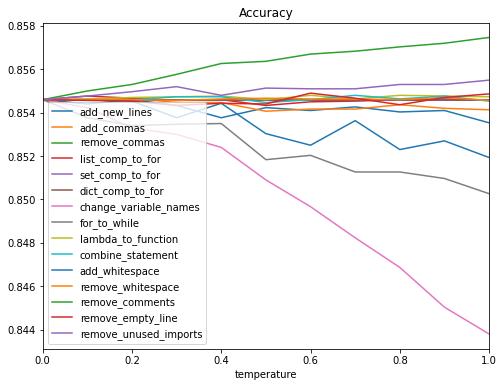

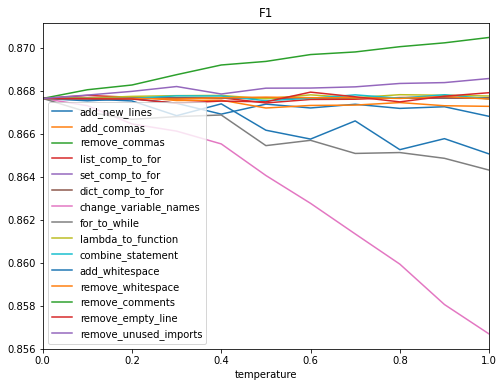

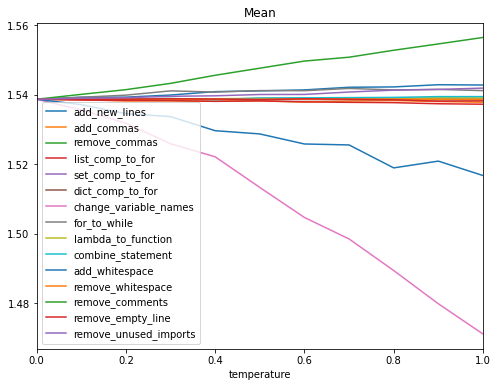

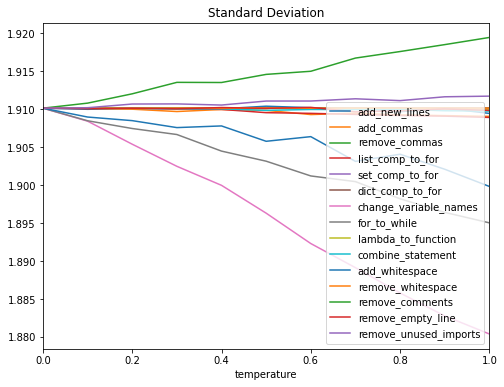

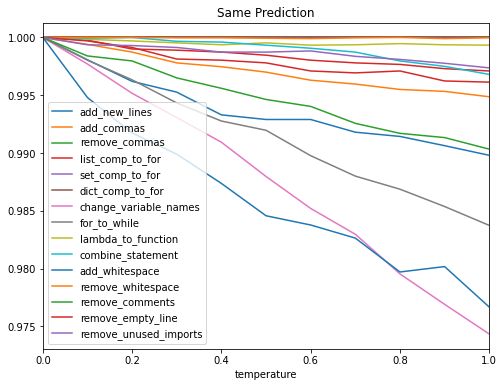

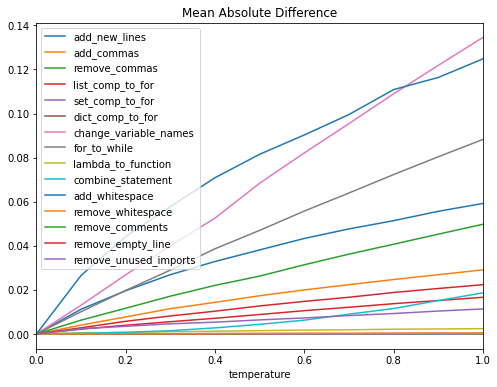

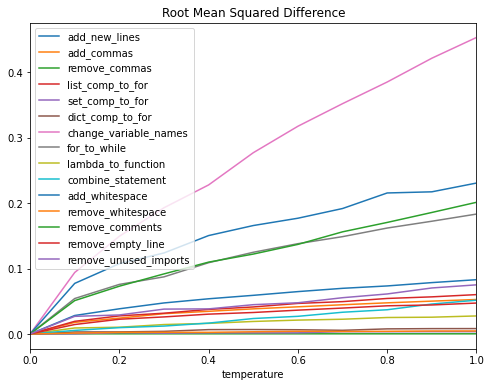

In [15]:
metrics_list = ['Accuracy', 'F1', 'Mean', 'Standard Deviation', 'Same Prediction', 'Mean Absolute Difference', 'Root Mean Squared Difference']

for metric in metrics_list:
    plt.figure(figsize=(8, 6))
    for transformation_type in transformation_types:
        plt.plot(x, [results[transformation_type][p][metric] for p in targets], label=transformation_type)

    plt.title(metric)
    plt.xlabel('temperature')
    plt.xlim((0.0, 1.0))
    plt.legend()
    plt.show()